In [1]:
import sys
sys.path.append('../')

from utils.whatsapp import preprocesamiento

In [2]:
pirobos = preprocesamiento()

path = '../data/sofi_historico.txt' #'../data/pirochismes_historico.txt'
chat = pirobos.leer(path)
chat_limpio = pirobos.limpiar(chat)
df = pirobos.convertir_a_dataframe(chat_limpio)

C:\Users\david\Desktop\proyectos\pirobos_unwrapped\notebooks\..\utils\whatsapp.py:52: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['fecha'] = df['fecha'].str.replace('.','').copy()


In [3]:
def limpiar_textos(messages:list,pct:float=0.005)->list:
    '''
    Estandariza los textos, elimina palabras extrañas, comunes y stopwords
    '''
    stop_words = set(stopwords.words('spanish'))
    
    sentence = ' '.join(messages).lower()
    sentence_jaja = re.sub(r'\w*jaja\w*','',sentence)

    words = re.findall(r'\w+',sentence_jaja,flags = re.UNICODE) 
    words_stopwords = [word for word in words if word not in stop_words]

    words_to_drop = round(len(set(words_stopwords))*pct/2)
    most_common = Counter(words_stopwords).most_common()[:words_to_drop]
    words_to_drop = round(len(set(words_stopwords))*pct)
    least_common = Counter(words_stopwords).most_common()[-words_to_drop:]
    commonwords = {word for word, time in most_common} | {word for word, time in least_common}
    
    final_words = [word for word in words_stopwords if word not in commonwords]
    final_sentence = ' '.join(final_words)
    
    return final_words, final_sentence


def graficar_wordcloud(sentence:str,name:str,save:bool=True) -> None:
    '''
    Grafica una nube de palabras
    '''
    wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                min_font_size = 10).generate(sentence)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    if save:
        plt.savefig('{}.png'.format(name))
    
    pass


def graficar_ngramcloud(final_words:list,n:int,name:str='ngram',save:bool=True)->None:
    '''
    Grafica una nube de ngramas
    '''
    grams = nltk.ngrams(final_words, n)
    list_gram = ['_'.join(gram) for gram in grams]
    str_gram = ' '.join(list_gram)

    graficar_wordcloud(str_gram,name,save)
    
    pass

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


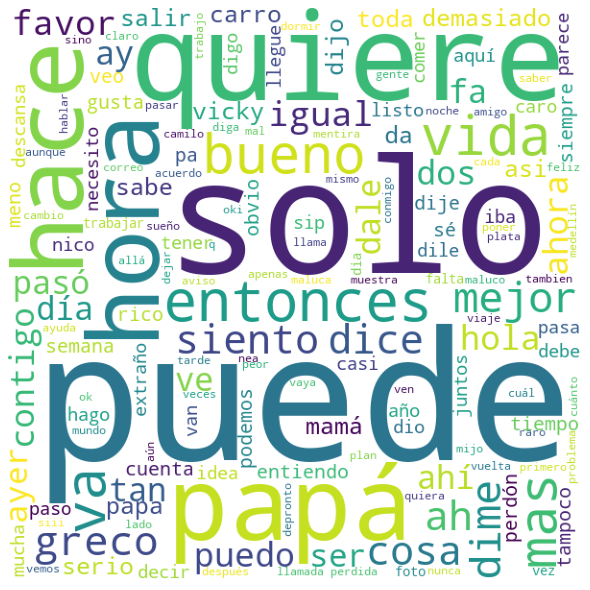

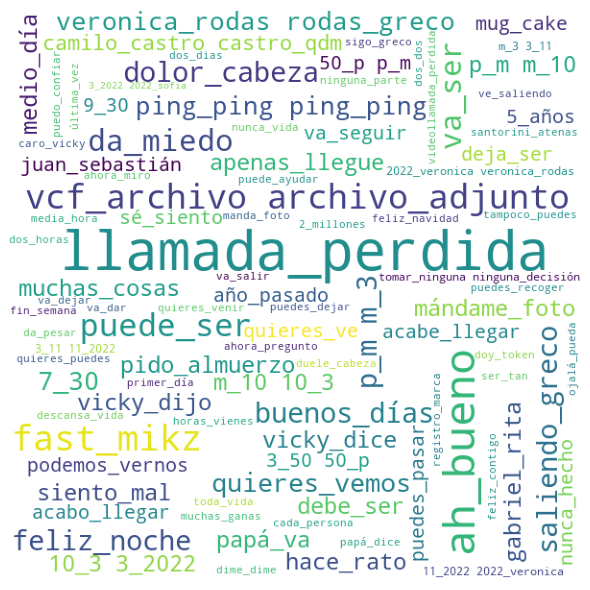

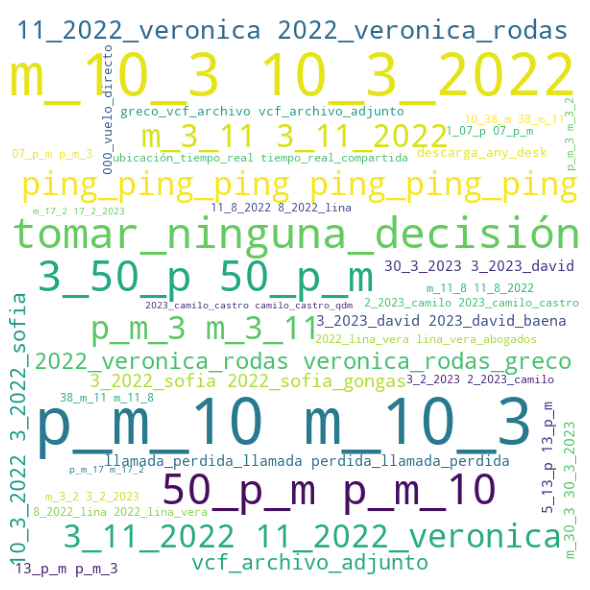

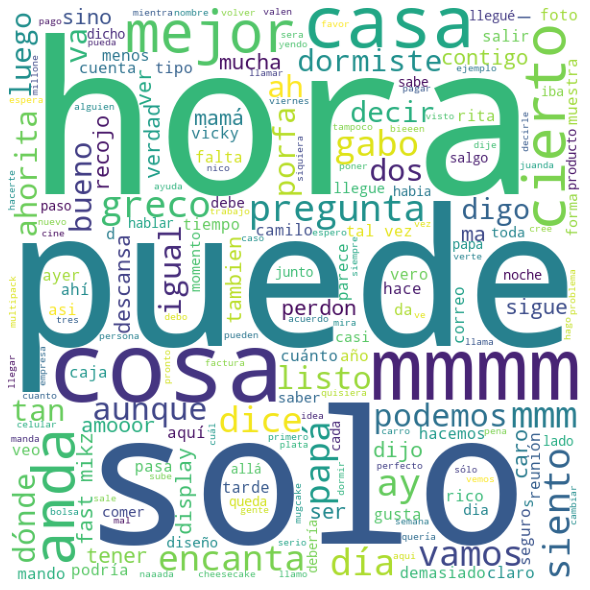

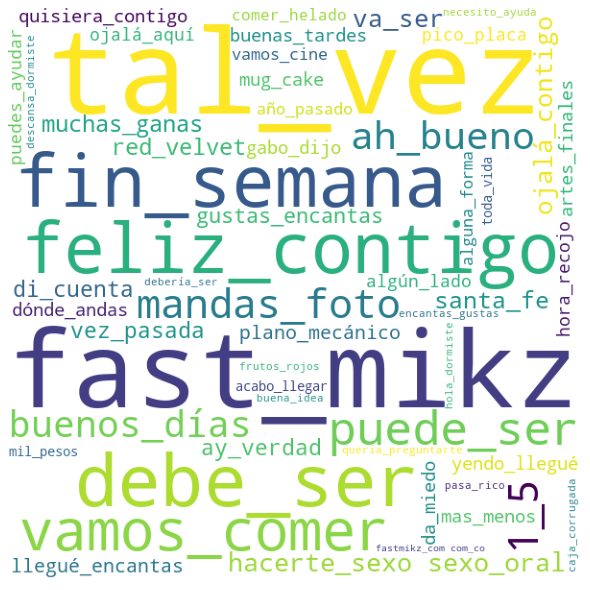

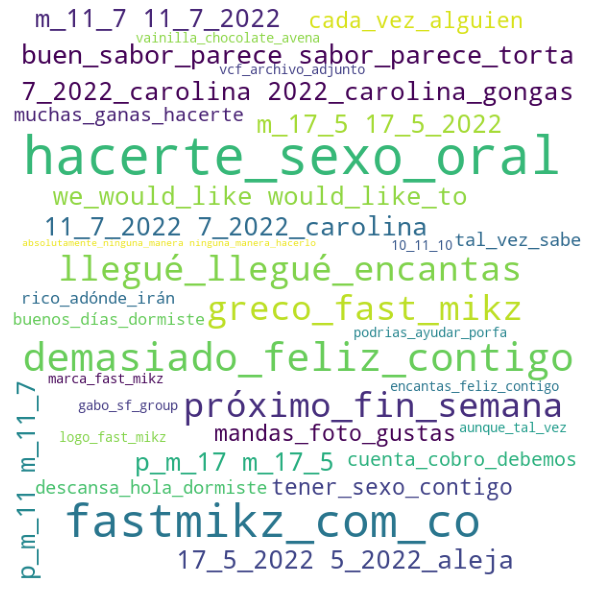

In [4]:
import numpy as np
import re

from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

pirobos = ['Sofía', 'David']
#pirobos = ['Ochoa', 'Vieco', 'Alejandro Gómez', 'Juan Sebastián', 'Juan David Arango', 'Checho', 'Esteban', 'Sierrita', 'David']

for pirobo in pirobos:
    
    mensaje_usuario = df.loc[(df['remitente'] == pirobo) &
                             (df['envia_link'] == False) &
                             (df['envia_multimedia'] == False) &
                             (df['elimina_info'] == False), 'mensaje'].str.strip().values
    
    palabras_finales, oracion_final = limpiar_textos(mensaje_usuario)
    
    graficar_wordcloud(oracion_final, 'palabras_{}'.format(pirobo))
    
    for n in [2,3]:
        graficar_ngramcloud(palabras_finales, n, '{0}gram_{1}'.format(n, pirobo))
    

In [5]:
df.groupby('remitente').size().sort_values()

remitente
Sofía    19083
David    20916
dtype: int64

In [6]:
df_unwrapped = df.copy()
df_unwrapped['cantidad_palabras'] = df_unwrapped['mensaje'].apply(lambda x: len(x.strip().split(' ')))
df_unwrapped.groupby('remitente')['cantidad_palabras'].mean().sort_values()

remitente
Sofía    4.166693
David    5.141423
Name: cantidad_palabras, dtype: float64

<AxesSubplot:xlabel='fecha'>

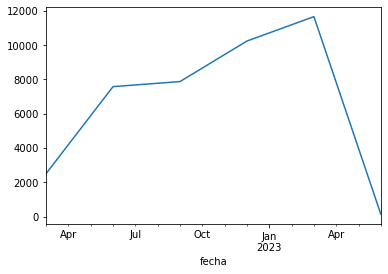

In [7]:
df.set_index('fecha').resample('3M').size().plot()
